In [180]:
import pandas as pd
import pickle
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import category_encoders as ce
import nltk.stem as stem
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec
import gensim
from sklearn.preprocessing import normalize

In [21]:
model = gensim.models.KeyedVectors.load_word2vec_format('models/GoogleNews-vectors-negative300.bin', binary=True)

In [170]:
data = pd.read_csv("Data/new_data.csv")

In [171]:
data = data.loc[(data['Price'] <= 900) & (data['Price'] >=200)]

In [172]:
data.shape

(4419, 10)

In [173]:
stemmer = stem.PorterStemmer()
stop_words = stopwords.words('english')

def stem_stop(input_text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(input_text.lower())
    tokens = [x for x in tokens if not x in stop_words]
    tokens_stemmed = [stemmer.stem(x) for x in tokens]
    return tokens_stemmed

In [174]:
def get_mean_vector(word2vec_model, words):
    words = [word for word in words if word in word2vec_model.vocab]
    if len(words) >= 1:
        return np.mean(word2vec_model[words], axis=0)
    else:
        return np.zeroes(300)

In [175]:
def get_word_vectors(df):
    sentences_train = list(df)
    sentences_train = [stem_stop(i) for i in sentences_train]
    sentences_train = np.array([get_mean_vector(model, i) for i in sentences_train])
    headers = ["Wordvec"+ str(i) for i in range(300)]
#     sentences_train = pd.DataFrame(data=sentences_train, columns=headers)
    return sentences_train

In [59]:
sentences = get_word_vectors(data['Synopsis'])

In [176]:
data = data.drop(columns=['Title', 'Edition_year', 'Synopsis'])

In [61]:
headers = ["Wordvec"+ str(i) for i in range(300)]
sentences = pd.DataFrame(data=sentences , index=data.index, columns=headers)

In [62]:
sentences.shape

(4419, 300)

In [63]:
data = pd.concat([data, sentences], axis=1)

In [177]:
data.shape

(4419, 7)

In [178]:
data.columns

Index(['Author', 'Reviews', 'Ratings', 'Genre', 'BookCategory', 'Price',
       'Edition_type'],
      dtype='object')

In [150]:
Y = data['Price']

In [151]:
X = data.drop(columns=['Price'])

In [152]:
ce_bin = ce.BinaryEncoder(cols = ['BookCategory', 'Genre','Author','Edition_type'])
X = ce_bin.fit_transform(X, Y)

In [181]:
X = normalize(X)

In [186]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [187]:
# x = pd.concat((x_train, y_train), axis=1)

In [188]:
# x = x.loc[(x['Price'] >=200) & (x['Price'] <=2000)]

In [189]:
# x_train = x.drop(columns=['Price'])

In [190]:
# y_train = x['Price']

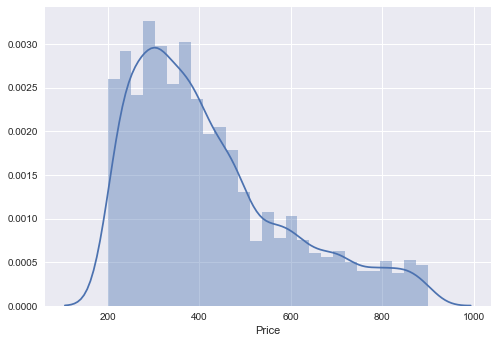

In [191]:
sns.distplot(y_train);
plt.show()

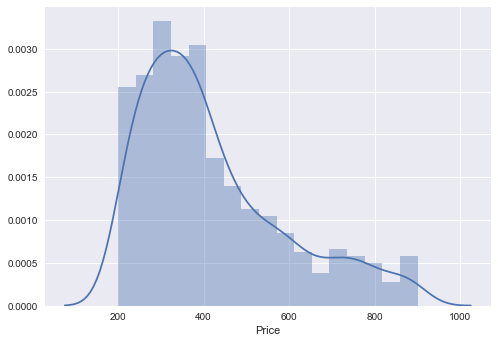

In [192]:
sns.distplot(y_test);
plt.show()

In [193]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3535, 29), (884, 29), (3535,), (884,))

In [217]:
reg_model = DecisionTreeRegressor(max_depth=2)

In [218]:
# reg_model = linear_model.Ridge(alpha=100.0,)

In [219]:
reg_model.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [220]:
print("Train error: ", np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train))))

Train error:  0.36909172831060144


In [221]:
predictions = list(reg_model.predict(x_test))

In [222]:
print("Test error: ", np.sqrt(mean_squared_log_error(y_test, predictions)))

Test error:  0.3692984393079537


In [164]:
np.argmax(reg_model.feature_importances_)

2

In [ ]:
# for i, j in zip(y_test[10:50], reg_model.predict(x_test)[10:50]):
#     print(i, j)

In [ ]:
# write predictions to an excel file

# preds = np.array(predictions)
# preds = pd.DataFrame(preds, columns=['Price'])
# preds.to_excel("submission.xlsx", index=None)

In [101]:
train_errors, test_errors, depths = [], [], []

In [102]:
for depth in range(2, 30):
    reg_model = DecisionTreeRegressor(max_depth=depth)
    reg_model.fit(x_train, y_train)
    train_err = np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train)))
    test_err = np.sqrt(mean_squared_log_error(y_test, reg_model.predict(x_test)))
    train_errors.append(train_err)
    test_errors.append(test_err)
    depths.append(depth)

In [103]:
d = pd.DataFrame({"train_error": train_errors, "test_error": test_errors, "depths": depths})

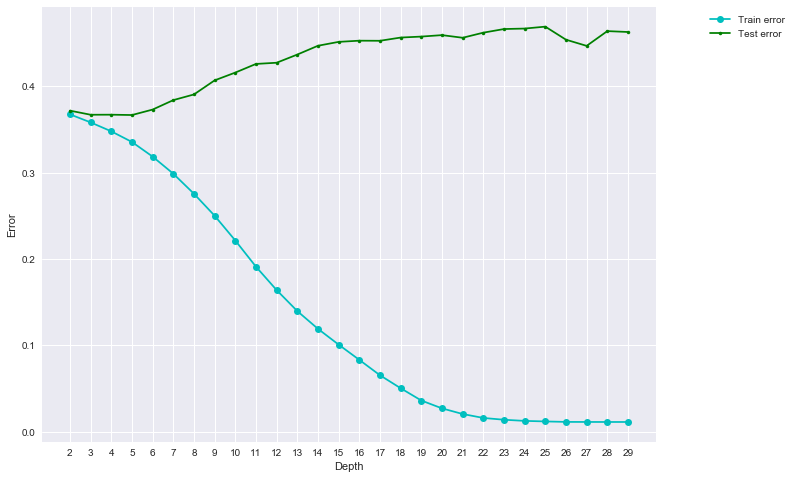

In [106]:
builds = d['depths']
y_stack = np.row_stack((d['train_error'], d['test_error'])) 

fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

ax1.plot(builds, y_stack[0,:], label='Train error', color='c', marker='o')
ax1.plot(builds, y_stack[1,:], label='Test error', color='g', marker='.')

plt.xticks(builds)
plt.xlabel('Depth')
plt.ylabel('Error')

handles, labels = ax1.get_legend_handles_labels()
lgd = ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.15,1))
ax1.grid('on')

plt.show()